<a href="https://colab.research.google.com/github/Abhishek734/Deep-learning-practice/blob/master/digit-recognition(mnist)/digit_recog_keras_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Disable warning
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# print(os.listdir("../input"))
print(os.getcwd())

/content


In [3]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishek734","key":"76a51ca69632519a143f4c34e281384a"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle competitions download -c digit-recognizer

 90% 66.0M/73.2M [00:00<00:00, 124MB/s]
100% 73.2M/73.2M [00:00<00:00, 165MB/s]
100% 48.8M/48.8M [00:00<00:00, 83.7MB/s]

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 53.4MB/s]


In [20]:
os.listdir("/content")

['.config',
 'train.csv',
 'kaggle.json',
 'sample_submission.csv',
 'test.csv',
 'sample_data']

In [0]:
FAST_RUN=False
batch_size=32
epochs=100
if FAST_RUN:
    epochs=1

In [0]:
train_data = pd.read_csv("train.csv")
test_data  = pd.read_csv("test.csv") 

In [23]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
train_data.shape

(42000, 785)

In [28]:
test_data.shape

(28000, 784)

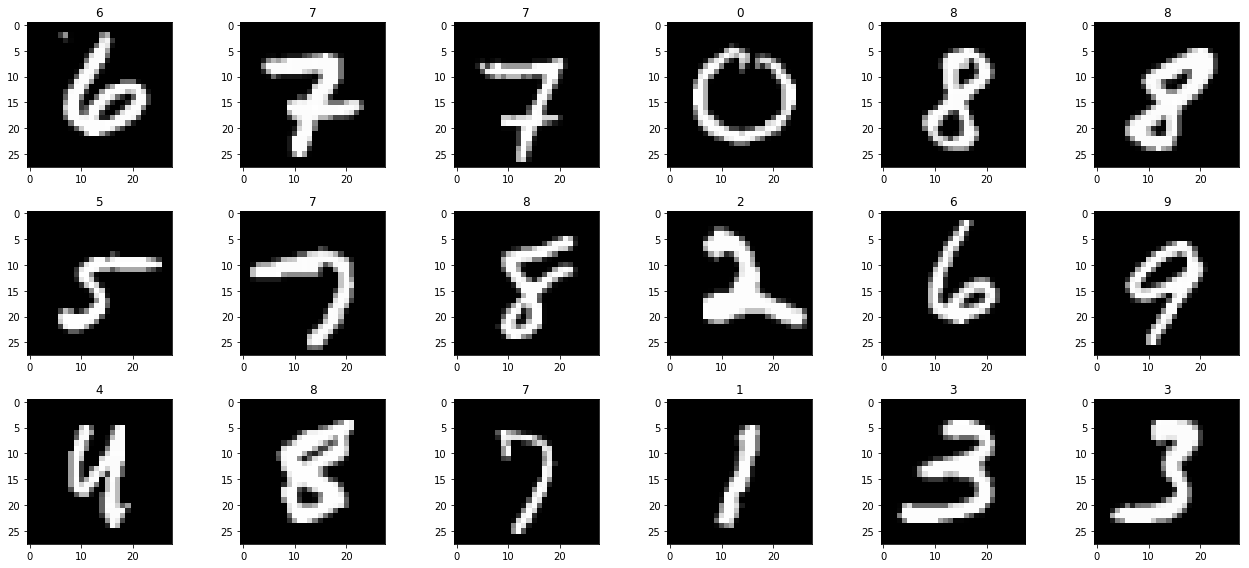

In [46]:
# lets transform 784 pixels to images

def conv_img(train_image, label, index):
    image_shaped = train_image.values.reshape(28,28)
    plt.subplot(3,6,index+1)
    plt.imshow(image_shaped, cmap=plt.cm.gray)
    plt.title(label)


plt.figure(figsize=(18, 8))
sample_image = train_data.sample(18).reset_index(drop=True)
for index, row in sample_image.iterrows():
    # print(row)
    label = row['label']
    image_pixels = row.drop('label')
    conv_img(image_pixels, label, index)

plt.tight_layout()

In [0]:
# lets prepare the data
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x = train_data.drop(columns=['label']).values.reshape(train_data.shape[0],28,28,1)
y = to_categorical(train_data['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(x_test)
validation_generator = validation_datagen.flow(
    x_test,
    y_test
    
)

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
Total params: 65,194
Trainable params: 65,194
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [76]:
# Fit model
model.fit_generator(
    train_generator, 
    steps_per_epoch=len(x_train) // batch_size, 
    validation_data=validation_generator,
    validation_steps=len(x_test) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
1181/1181 [==============================] - 27s 23ms/step - loss: 0.3977 - acc: 0.8772 - val_loss: 0.0976 - val_acc: 0.9678

Epoch 00001: val_loss improved from inf to 0.09762, saving model to model.h5
Epoch 2/100
1181/1181 [==============================] - 20s 17ms/step - loss: 0.1689 - acc: 0.9496 - val_loss: 0.0742 - val_acc: 0.9779

Epoch 00002: val_loss improved from 0.09762 to 0.07418, saving model to model.h5
Epoch 3/100
1181/1181 [==============================] - 21s 17ms/step - loss: 0.1356 - acc: 0.9600 - val_loss: 0.0781 - val_acc: 0.9762

Epoch 00003: val_loss did not improve from 0.07418
Epoch 4/100
1181/1181 [==============================] - 20s 17ms/step - loss: 0.1157 - acc: 0.9657 - val_loss: 0.0665 - val_acc: 0.9825

Epoch 00004: val_loss improved from 0.07418 to 0.06652, saving model to model.h5
Epoch 5/100
1181/1181 [==============================] - 20s 17

In [77]:
# Evaluate Model
x_test_recaled = (x_test.astype("float32") / 255)
scores = model.evaluate(x_test_recaled, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

acc: 98.69%
loss: 5.18%


In [0]:
# Prediction
test_digit_data = test_data.values.reshape(test_data.shape[0],28,28,1).astype("float32") / 255
predictions = model.predict(test_digit_data)
results = np.argmax(predictions, axis = 1) 

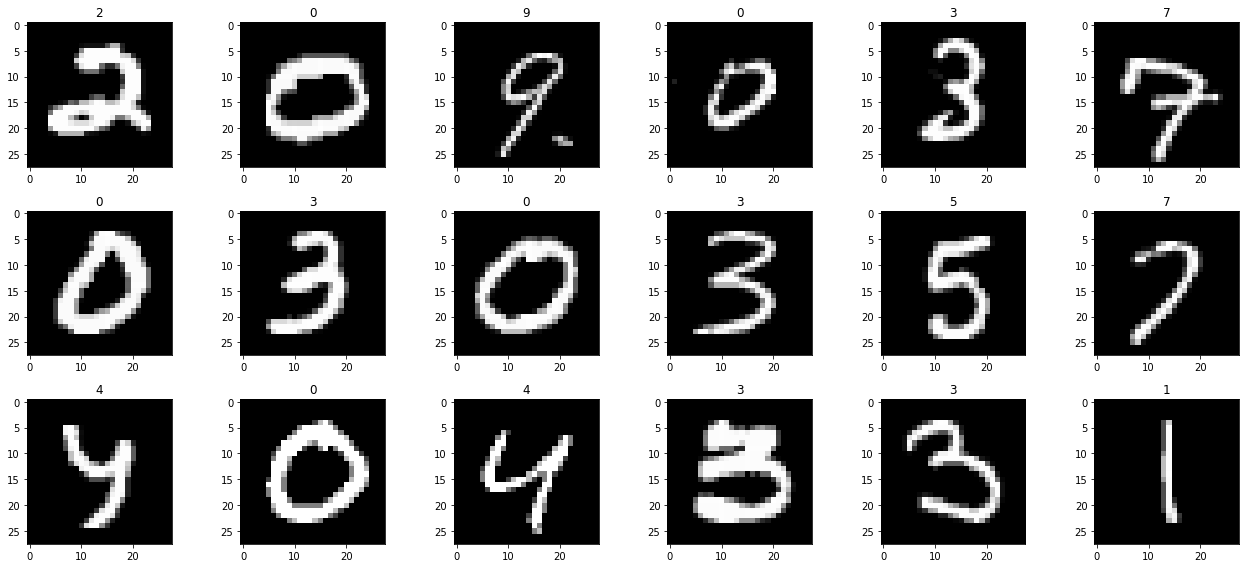

In [80]:
# Set how is our prediction
plt.figure(figsize=(18, 8))
sample_test = test_data.head(18)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    conv_img(image_pixels, label, index)
plt.tight_layout()

In [0]:
# Create submission file
submissions = pd.read_csv("sample_submission.csv")
submissions['Label'] = results
submissions.to_csv('submission.csv', index = False)